# PyTorch Training with SageMaker (Part 4/4)

Download | Structure | Preprocessing (PyTorch) | **Train Model (PyTorch)** 

**Notes**: 
* This notebook should be used with the conda_pytorch_latest_p36 kernel
* This notebook is part of a series of notebooks beginning with `01_download_data`, `02_structuring_data` and `03_pytorch_preprocessing`.
* You can also explore preprocessing with SageMaker's built-in algorithms and TensorFlow by running `04a_builtin_training` and `04c_tensorflow_training`, respectively.

<pre>
</pre>

In this notebook, you will train a model using the SageMaker SDK's TensorFlow framework on a remote EC2 instance. After training, you will load the trained model for predicting animal labels on your test dataset. 

<pre>
</pre>

## Overview
* #### [Dependencies](#idg4c.1)
* #### [Algorithm hyperparameters](#idg4c.2)
* #### [Review the training script](#idg4c.3)
* #### [Estimator configuration](#idg4c.4)
* #### [Training on EC2 instances](#idg4c.5)
* #### [Load trained model and predict](#idg4c.6)

<pre>
</pre>

<a id='idg4c.1'></a>
## Dependencies
___

### Import packages and check SageMaker version

In [2]:
import json
import torch
import tarfile
import pickle
import matplotlib.pyplot as plt
import torchvision as tv
import pathlib  # Path management tool (standard library)
import subprocess  # Runs shell commands via Python (standard library)
import sagemaker  # SageMaker Python SDK
from sagemaker.pytorch import PyTorch  # PyTorch Estimator for TensorFlow

### Load S3 bucket name & category labels
The `category_labels` file was generated from the first notebook in this series `01_download_data.ipynb`. You will need to run that notebook before running the code here. 

An S3 bucket for this guide was created in Part 3.

In [ ]:
with open("pickled_data/category_labels.pickle", "rb") as f:
    category_labels = pickle.load(f)

with open("pickled_data/pytorch_bucket_name.pickle", "rb") as f:
    bucket_name = pickle.load(f)
print(f"Using bucket: {bucket_name}")

<pre>
</pre>

<a id='idg4c.2'></a>
## Algorithm hyperparameters
___
Hyperparamters represent the tuning knobs for our algorithm which we set before training begins. Typically they are pre-set to defaults so if we don't specify them we can still run the training algorithm, but they usually need tweaking to get optimal results. What these values should be depend entirely on the dataset. Unfortunately, there's no formula to tell us what the best settings are, we just have to try them ourselves and see what we get, but there are best practices and tips to help guide us in choosing them.

* **Optimizer** - The optimizer refers to the optimization algorithm being used to choose the best weights. For deep learning on image data, SGD or ADAM is typically used.

* **Learning Rate** - After each batch of training we update the model's weights to give us the best possible results for that batch. The learning rate controls by how much we should update the weights. Best practices dictate a value between 0.2 and .001, typically never going higher than 1. The higher the learning rate, the faster your training will converge to the optimal weights, but going too fast can lead you to overshoot the target. In this example, we're using the weights from a pre-trained model so we'd want to start with a lower learning rate because the weights have already been optimized and we don't want move too far away from them.

*  **Epochs** - An epoch refers to one cycle through the training set and having more epochs to train means having more oppotunities to improve accracy. Suitable values range from 5 to 25 epochs depending on your time and budget constraints. Ideally, the right number of epochs is right before your validation accuracy plateaus.

* **Batch Size** - Training on batches reduces the amount of data you need to hold in RAM and can speed up the training algorithm. For these reasons the training data is nearly always batched. The optimal batch size will depended on the dataset, how large the images are and how much RAM the training computer has. For a dataset like ours reasonable vaules would be bewteen 8 and 64 images per batch.

* **Criterion** - This is the type of loss function that will be used by the optimizer to update the model's weights during training. For training on a dataset with with more than two classes, the most common loss function is Cross-Entropy Loss.

<pre>
</pre>

<a id='idg4c.3'></a>
## Review the training script
___

### The training function
Unlike other frameworks, PyTorch doesn't use model objects with a `.fit()` method to train them. Instead the user must define their own training function. This adds more code to our training script, but offers more transparency for customizing and debugging the model training. This is one major reasaon why researchers enjoy using PyTorch. In this example we use the training fuction defined in the PyTorch tutorial for transfer learning here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [5]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 12,78p

# the training fuction is based off the sample training fuction provided
# by Pytorch in their transfer learning tutorial:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train(model, criterion, optimizer, scheduler, epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero 

<pre>
</pre>

### Execution safety
For safety we wrap the training code in this standard if statement though it is not strictly required

In [9]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 81p

if __name__ =='__main__':


<pre>
</pre>

### Parse argument variables
These argument variables are passed via the hyperparameter argument for the estimator configuration.

In [10]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 83,90p

    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch-size', type=int, default=4)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--workers', type=int, default=0)

    args, _ = parser.parse_known_args()


<pre>
</pre>

### Define data transformations and load data
These are the transformations from the pre-processing guide. Since the data was resized before it was saved to S3, we don't need to do any resizing except for random cropping of the training dataset and center cropping the valications dataset.

In [11]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 92,127p

    data_dir = pathlib.Path('/opt/ml/input/data')

    # define transformations
    data_transforms = {
        'train': tv.transforms.Compose([
            tv.transforms.RandomResizedCrop(224),
            tv.transforms.RandomHorizontalFlip(p=0.5),
            tv.transforms.RandomVerticalFlip(p=0.5),
            tv.transforms.ColorJitter(
                brightness=.2, 
                contrast=.2, 
                saturation=.2, 
                hue=.2),
            tv.transforms.ToTensor()
        ]),
        'val': tv.transforms.Compose([
            tv.transforms.CenterCrop(224),
            tv.transforms.ToTensor()
        ]),
    }
    
    # create datasets and dataloaders
    splits = ['train', 'val']
    datasets = {}
    for s in splits:
        datasets[s] = tv.datasets.ImageFolder(
            root = data_dir / s, 
            transform = data_transforms[s])

    dataloaders = {}
    for s in splits:
        dataloaders[s] = torch.utils.data.DataLoader(
            dataset

<pre>
</pre>

### Detect device and create and modify the base model
The base model for this guide is a RestNet18 model using pre-trained weights. We need to modify the base model by replacing the fully connected layer with a dense layer to classify our animal images. The model is then loaded for the device (GPU or CPU) that our EC@ instance is using.

In [44]:
!pygmentize "pytorch_train/pytorch_train-revised.py" | sed -n 128,140p

    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
    num_classes = len(datasets['train'].classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    model = tv.models.resnet18(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    model = model.to(device)


<pre>
</pre>

### Define loss criterion, optimization algorithm and train the model
The weights for the epoch with the best accuracy are saved so we can load the model after training and make predictions on our test data.

In [45]:
!pygmentize "pytorch_train/pytorch_train-revised.py" | sed -n 142,150p

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model = train(model, criterion, optimizer, exp_lr_scheduler, epochs=args.epochs)
    
    model_dir = pathlib.Path(args.model_dir,)
    
    with open(model_dir / 'model.pth', 'wb') as f:
        torch.save(model.state_dict(), f)


<pre>
</pre>

<a id='idg4c.4'></a>
## Estimator configuration
___

These define the the resources to use for training and how they are configured. Here are some important one to single out:

* **entry_point (str)** – Path (absolute or relative) to the Python source file which should be executed as the entry point to training. If source_dir is specified, then entry_point must point to a file located at the root of source_dir.

* **framework_version (str)** – PyTorch version you want to use for executing your model training code. Defaults to None. Required unless image_uri is provided. List of supported versions: https://github.com/aws/sagemaker-python-sdk#pytorch-sagemaker-estimators.

* **py_version (str)** – Python version you want to use for executing your model training code. One of ‘py2’ or ‘py3’. Defaults to None. Required unless image_uri is provided.

* **source_dir (str)** – Path (absolute, relative or an S3 URI) to a directory with any other training source code dependencies aside from the entry point file (default: None). If source_dir is an S3 URI, it must point to a tar.gz file. Structure within this directory are preserved when training on Amazon SageMaker.

* **dependencies (list[str])** – A list of paths to directories (absolute or relative) with any additional libraries that will be exported to the container (default: []). The library folders will be copied to SageMaker in the same folder where the entrypoint is copied. If ‘git_config’ is provided, ‘dependencies’ should be a list of relative locations to directories with any additional libraries needed in the Git repo.

* **git_config (dict[str, str])** – Git configurations used for cloning files, including repo, branch, commit, 2FA_enabled, username, password and token. The repo field is required. All other fields are optional. repo specifies the Git repository where your training script is stored. If you don’t provide branch, the default value ‘master’ is used. If you don’t provide commit, the latest commit in the specified branch is used.

* **role (str)** – An AWS IAM role (either name or full ARN). The Amazon SageMaker training jobs and APIs that create Amazon SageMaker endpoints use this role to access training data and model artifacts. After the endpoint is created, the inference code might use the IAM role, if it needs to access an AWS resource.

* **instance_count (int)** – Number of Amazon EC2 instances to use for training.

* **instance_type (str)** – Type of EC2 instance to use for training, for example, ‘ml.c4.xlarge’.

* **volume_size (int)** – Size in GB of the EBS volume to use for storing input data during training (default: 30). Must be large enough to store training data if File Mode is used (which is the default).

* **model_uri (str)** – URI where a pre-trained model is stored, either locally or in S3 (default: None). If specified, the estimator will create a channel pointing to the model so the training job can download it. This model can be a ‘model.tar.gz’ from a previous training job, or other artifacts coming from a different source. In local mode, this should point to the path in which the model is located and not the file itself, as local Docker containers will try to mount the URI as a volume.

* **output_path (str)** - S3 location for saving the training result (model artifacts and output files). If not specified, results are stored to a default bucket. If the bucket with the specific name does not exist, the estimator creates the bucket during the fit() method execution. file:// urls are used for local mode. For example: ‘file://model/’ will save to the model folder in the current directory.

<pre>
</pre>

<a id='idg4c.5'></a>
## Training on an EC2 instance
___
Now that we've worked out any bugs in our trainging script we can send the training job to an EC2 instance with a GPU with a larger batch size, number of workers and number of epochs.

### Define the hyperparamters for EC2 training

In [6]:
hyperparameters = {"epochs": 10, "batch-size": 64, "learning-rate": 0.001, "workers": 4}

### Define the estimator configuration for EC2 training

In [7]:
estimator_config = {
    "entry_point": "pytorch_train.py",
    "source_dir": "training_pytorch",
    "framework_version": "1.6.0",
    "py_version": "py3",
    "instance_type": "ml.p3.2xlarge",
    "instance_count": 1,
    "role": sagemaker.get_execution_role(),
    "output_path": f"s3://{bucket_name}",
    "hyperparameters": hyperparameters,
}

### Create the estimator configured for EC2 training

In [8]:
pytorch_estimator = PyTorch(**estimator_config)

### Define the data channels using the proper S3 URIs

In [9]:
data_channels = {"train": f"s3://{bucket_name}/data/train", "val": f"s3://{bucket_name}/data/val"}

In [ ]:
pytorch_estimator.fit(data_channels)

<pre>
</pre>

<a id='idg4c.6'></a>
## Load the Trained Model and Predict
___
After training the model and saving its parameters (weights) to S3, we can retrive the parameters and load them back into PyTorch to generate predicions.

### Download the trained weights from S3

In [12]:
sagemaker.s3.S3Downloader().download(pytorch_estimator.model_data, "training_pytorch")
tf = tarfile.open("training_pytorch/model.tar.gz")
tf.extractall("training_pytorch")

### Load the weights back into a PyTorch model
Since the model was trained on a GPU we need to use the `map_location=torch.device('cpu')` kwarg to load the model on a CPU backed notebook instance.

In [13]:
model = tv.models.resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 11)
model.load_state_dict(torch.load("training_pytorch/model.pt", map_location=torch.device("cpu")))
model.eval();

### Link the model predictions (0 to 10) back to original class names (bear to zebra)
To map the index number back to the category label, we need to use the category labels created in the first guide of this series (Downloading Data).

In [14]:
category_labels = {idx: name for idx, name in enumerate(sorted(category_labels.values()))}
category_labels

{0: 'bear',
 1: 'bird',
 2: 'cat',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'frog',
 7: 'giraffe',
 8: 'horse',
 9: 'sheep',
 10: 'zebra'}

### Load validation images for predictions

In [15]:
test_ds = sample = tv.datasets.ImageFolder(
    root="data_resized/test",
    transform=tv.transforms.Compose([tv.transforms.CenterCrop(244), tv.transforms.ToTensor()]),
)

test_ds = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=True)

### Show validation images with model predictions

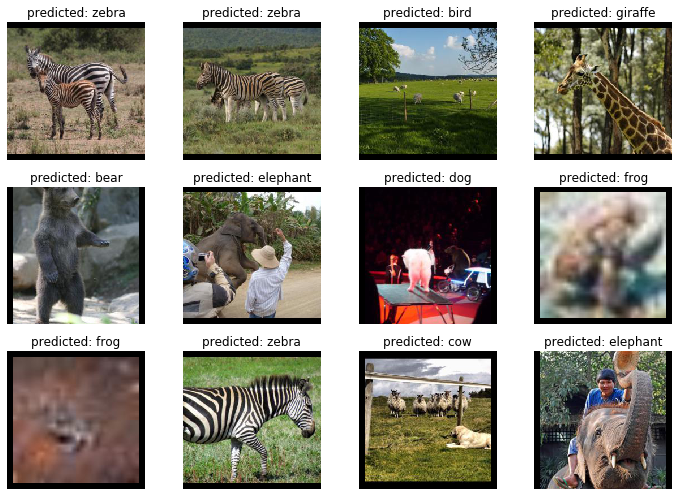

In [16]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(10, 7))

for row in range(rows):
    batch = next(iter(test_ds))
    images, labels = batch
    _, preds = torch.max(model(images), 1)
    preds = preds.numpy()
    for col, image in enumerate(images):
        ax = axs[row, col]
        ax.imshow(image.permute(1, 2, 0))
        ax.axis("off")
        ax.set_title(f"predicted: {category_labels[preds[col]]}")

plt.tight_layout()

<pre>
</pre>

## Rollback to default version of SDK and PyTorch
Only do this if you're done with this guide and want to use the same kernel for other notebooks with an incompatible version of the SageMaker SDK or PyTorch.

In [15]:
# print(f'Original version: sagemaker {original_sagemaker_version[0]}, torch {original_pytorch_version[0]}')
# print(f'Current version:  sagemaker {sagemaker.__version__}, torch {torch.__version__}')
# print('')
# print(f'Rolling back to sagemaker {original_sagemaker_version[0]}, torch {original_pytorch_version[0]}')
# print('Restart notebook kernel to use changes.')
# print('')
# s = f'sagemaker=={original_sagemaker_version[0]} torch=={original_pytorch_version[0]}'
# !{sys.executable} -m pip install {s}

<pre>
</pre>

## Next Steps
This concludes the Image Data Guide for SageMaker's PyTorch framework. If you'd like to deploy your model and get predictions on your test data, all the info you'll need to get going can be foud here: [Deploy Models for Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html)